# Predicting the Sale Price of Bulldozers Using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem Definition
> How well can we predict the future sale price of a bulldozer given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data
The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets: 

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012, You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation
The evaluation metric for this project is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build an ML model which minimizes RMSLE.

## 4. Features
Kaggle provides a data dictionary detailing all the features of the dataset. You can view this data dictionary in `data/bluebook-for-bulldozers/Data Dictionary.xlsx`


In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Import training and validation sets
df = pd.read_csv(
    'data/bluebook-for-bulldozers/TrainAndValid.csv',
    low_memory = False,
)

In [9]:
# Get some information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [11]:
# Check for missing values
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

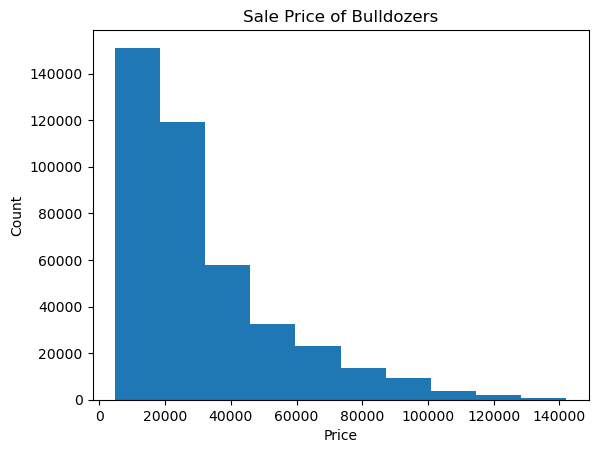

In [15]:
# Visualize our data
df.SalePrice.plot.hist()

# Adding a title and labels
plt.title('Sale Price of Bulldozers')
plt.xlabel('Price')
plt.ylabel('Count')

# Display the plot
plt.show();

### Parsing Dates

When we work with time series data, we want to enrich the time and date component as much as possible.

We can do that by telling Pandas which of our columns has dates in it using the `parse_dates` argument.

In [16]:
# Import data again but this time parse dates

df = pd.read_csv(
    'data/bluebook-for-bulldozers/TrainAndValid.csv',
    low_memory = False,
    parse_dates = ['saledate'],
)

In [17]:
df.saledate.dtype

dtype('<M8[ns]')

In [19]:
df.saledate.head()

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

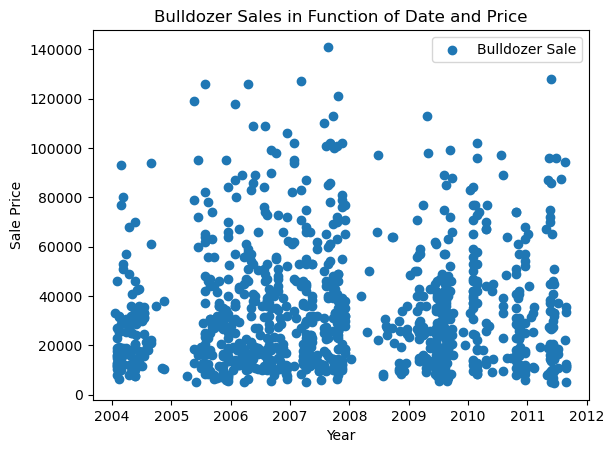

In [28]:
# Plot the data
fig, ax = plt.subplots()
ax.scatter(
    df['saledate'][:1000],
    df['SalePrice'][:1000],
)
# Add some helpful information
plt.title('Bulldozer Sales in Function of Date and Price')
plt.xlabel('Year')
plt.ylabel('Sale Price')
plt.legend(['Bulldozer Sale']);

In [30]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [32]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by sale-date

When working with time series data, it's a good idea to sort it by date.

In [37]:
# Sort DataFrame in date order
df.sort_values(
    by = ['saledate'],
    inplace = True,
    ascending = True,
)
df.saledate.head(20)

205615   1989-01-17
128751   1989-01-31
67974    1989-01-31
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [38]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
128751,1477524,10000.0,1078853,4103,132,99.0,1972,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Angle,None or Unspecified,NaN,NaN
67974,1344379,70000.0,1374638,3819,132,99.0,1982,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN


### Make a copy of the original DataFrame

We make a copy of the original DataFrame so when we manipulate the copy, we still got our original data.

In [39]:
# Make a copy
df_temp = df.copy()

### Feature Engineering: add datetime parameters for `saledate` column

In [47]:
df_temp['saleYear'] = df_temp.saledate.dt.year
df_temp['saleMonth'] = df_temp.saledate.dt.month
df_temp['saleDay'] = df_temp.saledate.dt.day
df_temp['saleDayOfWeek'] = df_temp.saledate.dt.dayofweek
df_temp['saleDayOfYear'] = df_temp.saledate.dt.dayofyear

df_temp.head().T

,205615,128751,67974,274835,141296
SalesID,1646770,1477524,1344379,1821514,1505138
SalePrice,9500.0,10000.0,70000.0,14000.0,50000.0
MachineID,1126363,1078853,1374638,1194089,1473654
ModelID,8434,4103,3819,10150,4139
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1972,1982,1980,1978
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [48]:
# Now we've enriched our DataFrame with date time features, we can remove saledate
df_temp.drop(
    'saledate',
    axis = 1,
    inplace = True,
)

In [49]:
# Check the values of different columns
df_temp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

### Convert strings to categories

One way we can turn all our data into numbers is by converting them into Pandas categories.

In [51]:
df_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
128751,1477524,10000.0,1078853,4103,132,99.0,1972,NaN,NaN,D4D,...,None or Unspecified,Angle,None or Unspecified,NaN,NaN,1989,1,31,1,31
67974,1344379,70000.0,1374638,3819,132,99.0,1982,NaN,NaN,950B,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31


In [52]:
pd.api.types.is_string_dtype(df_temp['UsageBand'])

False

In [53]:
# Find the columns which contain strings
for label, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

fiModelDesc
fiBaseModel
fiProductClassDesc
state
ProductGroup
ProductGroupDesc


In [55]:
# This will turn all the str values into category values
for label, content in df_temp.items():
    if pd.api.types.is_string_dtype(content):
        df_temp[label] = content.astype('category').cat.as_ordered()

In [58]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   object  
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  object  
 12  fiModelSeries             58667 non-null   object  
 13  fiModelDescriptor         748

In [60]:
df_temp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [61]:
df_temp.state.cat.codes

205615    43
128751     8
67974      8
274835     8
141296     8
          ..
409202     4
411890     4
408976     4
409297     4
409203     4
Length: 412698, dtype: int8

Thanks to Pandas categories, we now have a way to access all our data in the form of numbers.

But we still have lots of missing data.

In [62]:
# Check missing data
df_temp.isnull().sum() / len(df_temp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data

In [63]:
# Export current temp DataFrame
df_temp.to_csv(
    'data/bluebook-for-bulldozers/train_tmp.csv',
    index = False
)

In [64]:
# Import preprocessed data
df_temp = pd.read_csv(
    'data/bluebook-for-bulldozers/train_tmp.csv',
    low_memory = False,
)
df_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
1,1477524,10000.0,1078853,4103,132,99.0,1972,NaN,NaN,D4D,...,None or Unspecified,Angle,None or Unspecified,NaN,NaN,1989,1,31,1,31
2,1344379,70000.0,1374638,3819,132,99.0,1982,NaN,NaN,950B,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
3,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
4,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31


In [65]:
df_temp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## Fill Missing Values

### Fill numeric missing values first


In [68]:
# Check which numeric columns have null values
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [69]:
# Fill numeric rows with the median
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_temp[label + '_is_missing'] = pd.isnull(
                content)  # Add a binary column which tells us if the data was missing or not
            df_temp[label] = content.fillna(content.median())  # Fill missing numeric values with the median

In [73]:
# Check if there's any null numeric values
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [74]:
# Check to see how many examples were missing
df_temp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

In [75]:
# Check remaining missing rows
df_temp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling and turning categorical variables into numbers

In [76]:
# Check for columns which aren't numeric
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [80]:
# Turn categorical variables into numbers and fill missing data
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_temp[label + '_is_missing'] = pd.isnull(
            content)  # Add binary column to indicate whether sample has missing value
        df_temp[label] = pd.Categorical(
            content).codes + 1  # Turn categories into numbers and add +1 to ensure only values are >= 0

In [81]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [82]:
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1477524,1344379,1821514,1505138
SalePrice,9500.0,10000.0,70000.0,14000.0,50000.0
MachineID,1126363,1078853,1374638,1194089,1473654
ModelID,8434,4103,3819,10150,4139
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,False,True,True,False
Blade_Type_is_missing,False,False,True,True,False
Travel_Controls_is_missing,False,False,True,True,False
Differential_Type_is_missing,True,True,False,False,True


In [83]:
# Check to make sure we have no more missing values and all our data is numeric
df_temp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

## 5. Modelling
Now that all our data is numeric and our dataframe has no missing values, let's start with some model-driven EDA (Exploratory Data Analysis).

In [85]:
%%time

from pandas import DataFrame

# Instantiate model
model = RandomForestRegressor(
    n_jobs = -1,
    random_state = 42,
)

# Split data into X and y
X: DataFrame = df_temp.drop('SalePrice', axis = 1)
y: DataFrame = df_temp['SalePrice']

# Fit the model
model.fit(X, y);

CPU times: user 26min 57s, sys: 20.9 s, total: 27min 17s
Wall time: 4min


### Splitting data into train/validation sets

In [88]:
# Split data intro training and validation sets
df_val = df_temp[df_temp.saleYear == 2012]
df_train = df_temp[df_temp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [89]:
# Split data into X and y training sets
X_train, y_train = df_train.drop('SalePrice', axis = 1), df_train.SalePrice
X_valid, y_valid = df_val.drop('SalePrice', axis = 1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [93]:
X_train, X_valid

(        SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
 0       1646770    1126363     8434         132          18.0      1974   
 1       1477524    1078853     4103         132          99.0      1972   
 2       1344379    1374638     3819         132          99.0      1982   
 3       1821514    1194089    10150         132          99.0      1980   
 4       1505138    1473654     4139         132          99.0      1978   
 ...         ...        ...      ...         ...           ...       ...   
 401120  6260687    1074871     4331         149           2.0      1000   
 401121  6312170    1812622     9580         149           2.0      2005   
 401122  6312727    1811599     9580         149           2.0      2005   
 401123  6315051    1858173    17432         149           2.0      2004   
 401124  6261980    1557037     1211         149           2.0      1000   
 
         MachineHoursCurrentMeter  UsageBand  fiModelDesc  fiBaseModel  ...  \
 0     

In [94]:
y_train, y_valid

(0          9500.0
 1         10000.0
 2         70000.0
 3         14000.0
 4         50000.0
            ...   
 401120    29000.0
 401121    11000.0
 401122    11000.0
 401123    18000.0
 401124    43500.0
 Name: SalePrice, Length: 401125, dtype: float64,
 401125    46173.2
 401126    62100.0
 401127    35000.0
 401128    64000.0
 401129    28000.0
            ...   
 412693    35000.0
 412694    11000.0
 412695     7500.0
 412696    47000.0
 412697    34000.0
 Name: SalePrice, Length: 11573, dtype: float64)

### Building an evaluation function

In [95]:
from typing import Dict
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score


# Create evaluation function
def rmsle(y_test: DataFrame, y_preds: DataFrame) -> float:
    """
    Calculates the Root Mean Squared Logarithmic Error (RMSLE) between the true labels and the predicted values.
    
    RMSLE is a metric used to measure the difference between predicted values and actual values.
    It is useful for regression problems where we want to penalize underestimations more than overestimations.
    The error is calculated as the square root of the mean squared logarithmic error.

    :param y_test: DataFrame
        The actual values/labels.
    :param y_preds: DataFrame
        The predicted values/labels.
    :return: The calculated RMSLE value.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))


# Create function to evaluate model on a few different levels
def show_scores(model: RandomForestRegressor) -> Dict[str, float]:
    """
    Evaluates the performance of a given RandomForestRegressor model on training and validation datasets
    using multiple metrics and returns the results as a dictionary.

    The function computes the following metrics for both training and validation sets:
    - Mean Absolute Error (MAE)
    - Root Mean Squared Logarithmic Error (RMSLE)
    - R-squared (R^2) score

    :param model: RandomForestRegressor
        The machine learning model to evaluate.
    :return: Dict[str, float]
        A dictionary containing the calculated evaluation metrics for both training and validation datasets.
    """
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {
        'Training MAE': mean_absolute_error(y_train, train_preds),
        'Valid MAE': mean_absolute_error(y_valid, val_preds),
        'Training RMSLE': rmsle(y_train, train_preds),
        'Valid RMSLE': rmsle(y_valid, val_preds),
        'Training R^2': r2_score(y_train, train_preds),
        'Valid R^2': r2_score(y_valid, val_preds),
    }
    return scores

# Reducing Data
## Testing our model on a subset (to tune the hyperparameters)

In [99]:
# Change max_samples value
model = RandomForestRegressor(
    n_jobs = -1,
    random_state = 42,
    max_samples = 10000,
)

In [101]:
%%time
# Cutting down on the max number of samples each estimator sees improves training time
model.fit(X_train, y_train);

CPU times: user 40.4 s, sys: 886 ms, total: 41.3 s
Wall time: 7.04 s


In [102]:
show_scores(model)

{'Training MAE': 5558.077404624494,
 'Valid MAE': 7151.689255162879,
 'Training RMSLE': 0.2574720640640487,
 'Valid RMSLE': 0.2930897144632455,
 'Training R^2': 0.8606189277806695,
 'Valid R^2': 0.8334505854823815}

### Hyperparameter tuning with RandomizedSearchCV

In [111]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {
    'n_estimators': np.arange(10, 100, 10),
    'max_depth': [
        None,
        3,
        5,
        10,
    ],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_features': [0.5, 1, 'sqrt', 'log2'],
    'max_samples': [10000],
}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(
    RandomForestRegressor(
        n_jobs = -1,
        random_state = 42
    ),
    param_distributions = rf_grid,
    n_iter = 100,
    cv = 5,
    verbose = True,
)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 28min 15s, sys: 2min 41s, total: 30min 56s
Wall time: 10min 5s


In [112]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [113]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 6022.658667661587,
 'Valid MAE': 7393.74497036734,
 'Training RMSLE': 0.2743893269703703,
 'Valid RMSLE': 0.30376025025399334,
 'Training R^2': 0.8397247162929906,
 'Valid R^2': 0.8274172245100808}

## Improving Hyperparameters
Training a model with the best hyperparameters

In [115]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(
    n_estimators = 70,
    min_samples_split = 14,
    min_samples_leaf = 1,
    max_features = 0.5,
    n_jobs = -1,
    random_state = 42,
)
# Fit the ideal model
ideal_model.fit(X_train, y_train);

CPU times: user 7min 15s, sys: 4.35 s, total: 7min 20s
Wall time: 1min 2s


In [116]:
# Scores for ideal_model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 2932.8108466928106,
 'Valid MAE': 5937.212747110798,
 'Training RMSLE': 0.14356101283810696,
 'Valid RMSLE': 0.24504779263435655,
 'Training R^2': 0.9596050402766756,
 'Valid R^2': 0.8824784247820165}

In [117]:
# Scores on rs_model (only trained on 10,000 examples)
show_scores(rs_model)

{'Training MAE': 6022.658667661585,
 'Valid MAE': 7393.74497036734,
 'Training RMSLE': 0.2743893269703703,
 'Valid RMSLE': 0.30376025025399334,
 'Training R^2': 0.8397247162929906,
 'Valid R^2': 0.8274172245100808}

## Make predictions on test data

In [162]:
# Import the test data
df_test = pd.read_csv(
    'data/bluebook-for-bulldozers/Test.csv',
    low_memory = False,
    parse_dates = ['saledate'],
)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [163]:
def preprocess_data(df: DataFrame) -> DataFrame:
    """
    Preprocesses the input DataFrame by extracting date information, 
    filling missing values for numeric and categorical columns, and 
    adding binary columns to indicate missing values.

    :param df: DataFrame
        The input DataFrame containing the raw data.
    :return: The preprocessed DataFrame with extracted date features and filled missing values.
    """
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear

    df.drop('saledate', axis = 1, inplace = True)

    df = fill_missing_numeric_values(df)
    df = fill_missing_categorical_values(df)
    
    return df

def fill_missing_numeric_values(df: DataFrame) -> DataFrame:
    """
    Fills missing values in numeric columns with the median value and 
    adds a binary column to indicate missing values.

    :param df: DataFrame
        The input DataFrame containing the raw data.
    :return: The DataFrame with filled missing values in numeric columns.
    """
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label + '_is_missing'] = pd.isnull(content)  # Add a binary column which tells us if the data was missing or not
                df[label] = content.fillna(content.median())  # Fill missing numeric values with the median
    return df

def fill_missing_categorical_values(df: DataFrame) -> DataFrame:
    """
    Fills missing values in categorical columns and turns categories into numbers. 
    Adds a binary column to indicate missing values.

    :param df: DataFrame
        The input DataFrame containing the raw data.
    :return: The DataFrame with filled missing values in categorical columns.
    """
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label + '_is_missing'] = pd.isnull(content)  # Add binary column to indicate whether sample has missing value
            df[label] = pd.Categorical(content).codes + 1  # Turn categories into numbers and add +1 to ensure only values are >= 0
    return df


In [164]:
# Process the test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [165]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [166]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test['auctioneerID_is_missing'] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [167]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1477524,1078853,4103,132,99.0,1972,0.0,0,2169,692,...,True,True,True,True,True,False,False,False,True,True
2,1344379,1374638,3819,132,99.0,1982,0.0,0,1740,529,...,True,True,True,True,True,True,True,True,False,False
3,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
4,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True


Our test dataframe now has the same features as our training dataframe. 

We can make predictions

In [168]:
def align_columns(train_df: DataFrame, test_df: DataFrame) -> DataFrame:
    """
    Aligns the columns of the test DataFrame to match the training DataFrame by adding any missing columns
    and reordering the columns to match the training DataFrame.

    :param train_df: DataFrame
        The DataFrame containing the training data.
    :param test_df: DataFrame
        The DataFrame containing the test data.
    :return: DataFrame
        The test DataFrame with columns aligned to the training DataFrame.
    """
    # Find missing columns in test set
    missing_cols = set(train_df.columns) - set(test_df.columns)
    
    # Add missing columns to test set with default values
    for col in missing_cols:
        test_df[col] = 0
    
    # Reorder columns to match training set
    test_df = test_df[train_df.columns]
    
    return test_df

# Ensure df_test has the same columns as X_train
df_test = align_columns(X_train, df_test)

test_preds = ideal_model.predict(df_test)

In [170]:
test_preds

array([17187.35325576, 16045.08008675, 45831.96360963, ...,
       14217.15908639, 17523.94624946, 25945.00709077])

We've made some predictions, but they're not in the same format Kaggle is asking for
- https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [171]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalesPrice'] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,17187.353256
1,1227844,16045.080087
2,1227847,45831.963610
3,1227848,71142.209349
4,1227863,57597.826943
...,...,...
12452,6643171,41268.789426
12453,6643173,11594.328274
12454,6643184,14217.159086
12455,6643186,17523.946249


In [173]:
# Export to csv
df_preds.to_csv('data/bluebook-for-bulldozers/test_predictions.csv', index = False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable** (SalePrice)

In [174]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.43504080e-02, 1.86561133e-02, 4.17521433e-02, 1.74050007e-03,
       3.36062091e-03, 2.04013353e-01, 3.07839050e-03, 1.02642472e-03,
       4.84802453e-02, 3.81877368e-02, 6.58170707e-02, 4.95861471e-03,
       1.64977274e-02, 1.55862867e-01, 4.11230707e-02, 5.98991234e-03,
       1.94776855e-03, 1.88231305e-03, 4.11054724e-03, 5.99424919e-02,
       6.66740921e-04, 3.12024671e-05, 8.16796439e-04, 1.98959153e-04,
       1.63491577e-03, 3.30537438e-05, 1.27866127e-03, 1.20250568e-02,
       8.37032484e-04, 1.01401866e-04, 5.74314658e-03, 2.14287878e-03,
       3.21644909e-03, 1.93981878e-03, 2.98553234e-04, 7.04959762e-03,
       8.78814367e-04, 1.38456056e-02, 1.74398581e-03, 3.21413233e-03,
       9.77330536e-04, 9.07532345e-04, 2.61540887e-03, 5.73113945e-04,
       4.31089617e-04, 4.03518973e-04, 2.06294682e-04, 1.84668496e-03,
       1.09186525e-03, 2.47032038e-04, 1.01360429e-03, 7.33278483e-02,
       3.85337224e-03, 5.70327538e-03, 2.91700346e-03, 9.90773726e-03,
      

In [187]:
from typing import List

# Helper function for plotting feature importance
def plot_features(columns: List[str], importances: np.ndarray, n: int = 20) -> None:
    """
    Plots the top n feature importances from a trained machine learning model.

    :param columns: List of feature names.
    :param importances: Array of feature importance scores.
    :param n: Number of top features to plot (default is 20).
    :return: None
    """
    df = (pd.DataFrame({
        'features': columns,
        'feature_importances': importances,
    }).sort_values(
        'feature_importances',
        ascending = False,
    ).reset_index(
        drop = True
    ))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df['features'][:n], df['feature_importances'][:n])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature Importance')
    ax.invert_yaxis()


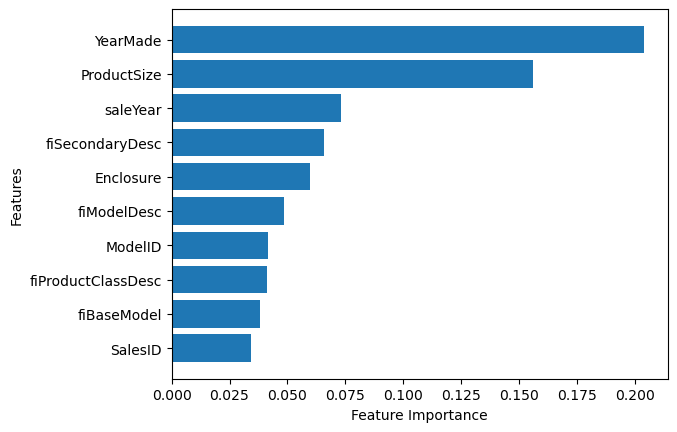

In [188]:
plot_features(X_train.columns, ideal_model.feature_importances_, n = 10)